In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_palette = sns.color_palette()

In [2]:
df = pd.read_csv('/kaggle/input/hourly-energy-consumption/PJME_hourly.csv')
df.head()

,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0


In [3]:
df.set_index('Datetime', inplace = True)
df.index = pd.to_datetime(df.index)
df.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


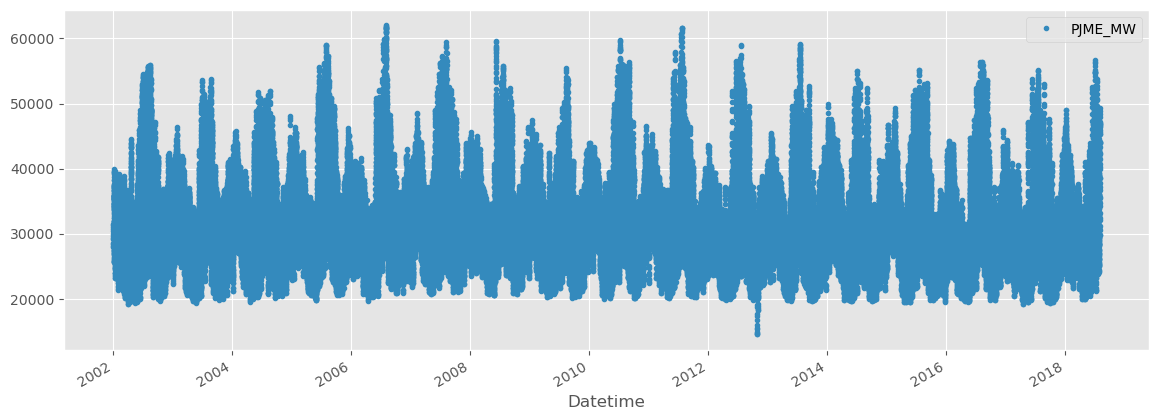

In [4]:
df.plot(style = '.', figsize = (14, 5), color = color_palette[1])
plt.show()
# color_palette

In [5]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

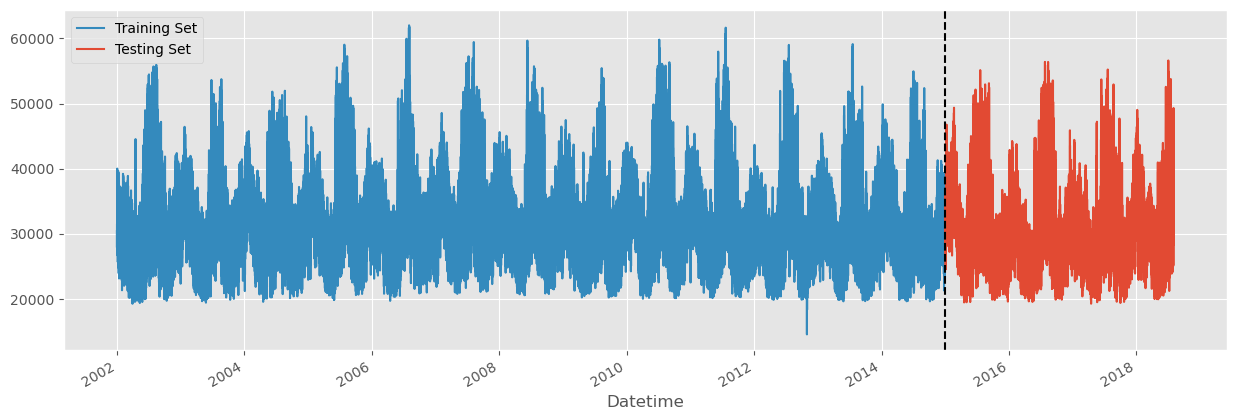

In [6]:
fig, ax = plt.subplots(figsize = (15, 5))
train.plot(ax = ax, label = 'Training', color = color_palette[1])
test.plot(ax = ax, label = "Testing", color = color_palette[0])
ax.axvline('01-01-2015', color = 'black', ls = '--' )
ax.legend(['Training Set', 'Testing Set'])
plt.show()

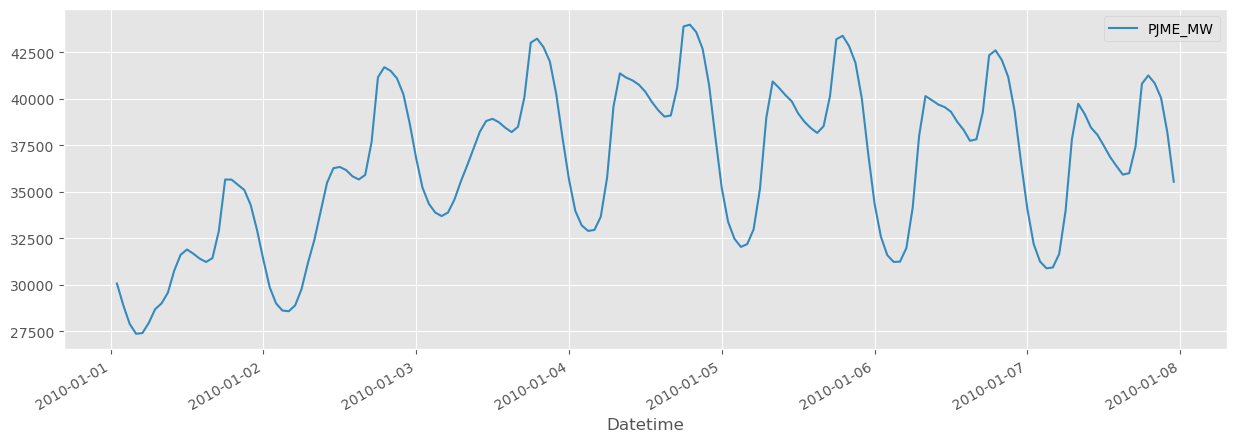

In [7]:
df.loc[(df.index > '01-01-2010') & (df.index < '01-08-2010')].plot(figsize = (15, 5), color = color_palette[1])
plt.show()

In [8]:
def create_features(df):
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    return df

In [9]:
df = create_features(df)
df

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear
Datetime,,,,,,,
2002-12-31 01:00:00,26498.0,1,1,4,12,2002,365
2002-12-31 02:00:00,25147.0,2,1,4,12,2002,365
2002-12-31 03:00:00,24574.0,3,1,4,12,2002,365
2002-12-31 04:00:00,24393.0,4,1,4,12,2002,365
2002-12-31 05:00:00,24860.0,5,1,4,12,2002,365
...,...,...,...,...,...,...,...
2018-01-01 20:00:00,44284.0,20,0,1,1,2018,1
2018-01-01 21:00:00,43751.0,21,0,1,1,2018,1
2018-01-01 22:00:00,42402.0,22,0,1,1,2018,1


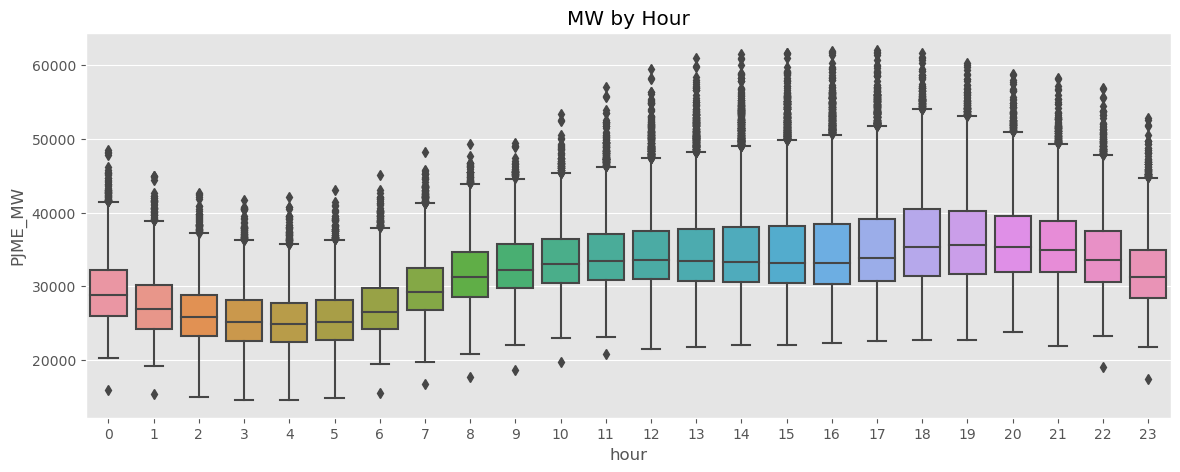

In [10]:
fig, ax = plt.subplots(figsize = (14, 5))
ax = sns.boxplot(data = df, x = 'hour', y = 'PJME_MW')
ax.set_title('MW by Hour')
plt.show()

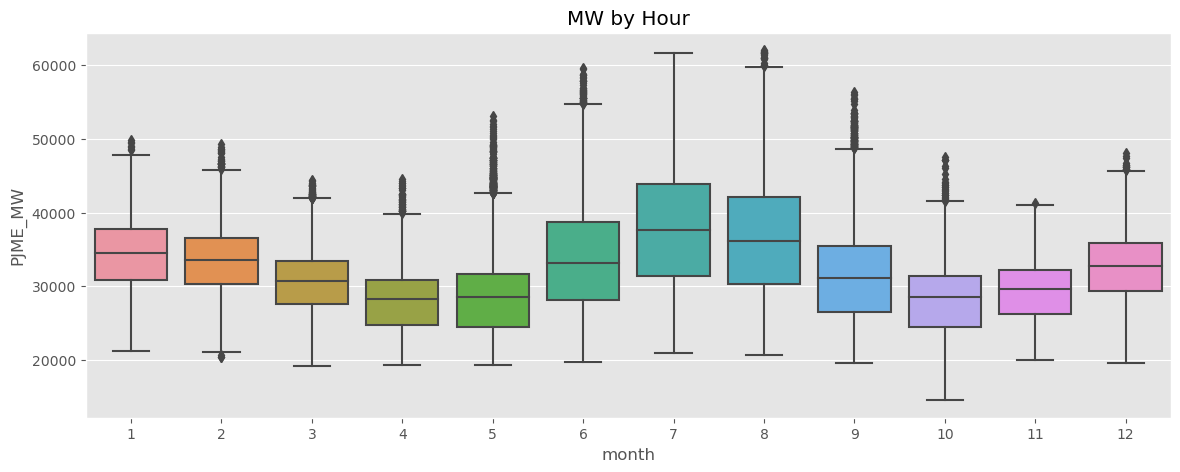

In [11]:
fig, ax = plt.subplots(figsize = (14, 5))
ax = sns.boxplot(data = df, x = 'month', y = 'PJME_MW')
ax.set_title('MW by Hour')
plt.show()

In [12]:
train = create_features(train)
test = create_features(test)

In [13]:
df.columns

Index(['PJME_MW', 'hour', 'dayofweek', 'quarter', 'month', 'year',
       'dayofyear'],
      dtype='object')

In [14]:
FEATURES = ['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear']
TARGET = 'PJME_MW'

In [15]:
X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [16]:
reg = xgb.XGBRegressor(n_estimators = 1000, early_stopping_rounds = 50, learning_rate = 0.01)
reg.fit(X_train, y_train, 
       eval_set = [(X_train, y_train), (X_test, y_test)],
       verbose = 100)

[0]	validation_0-rmse:32601.87826	validation_1-rmse:31654.28935
[100]	validation_0-rmse:12342.13873	validation_1-rmse:11517.66004
[200]	validation_0-rmse:5373.33346	validation_1-rmse:5165.30811
[300]	validation_0-rmse:3375.20923	validation_1-rmse:3829.25476
[400]	validation_0-rmse:2882.55200	validation_1-rmse:3715.04915
[437]	validation_0-rmse:2793.31200	validation_1-rmse:3727.16078


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=50, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, ...)

<AxesSubplot:>

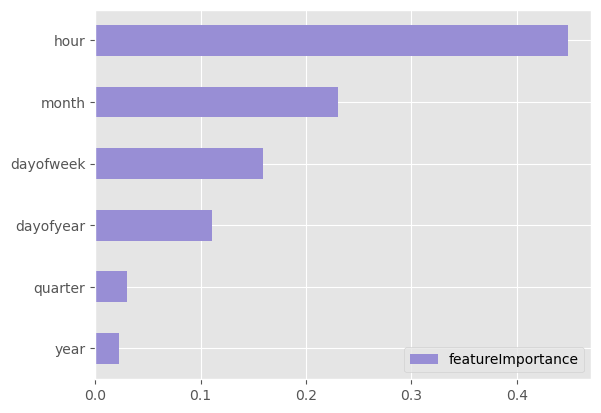

In [17]:
fi = pd.DataFrame(data = reg.feature_importances_, index = reg.feature_names_in_, columns = ['featureImportance'])
fi.sort_values('featureImportance').plot(kind = 'barh', color = color_palette[2])

In [18]:
test['prediction'] = reg.predict(X_test)

In [19]:
test.head()

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,prediction
Datetime,,,,,,,,
2015-01-01 00:00:00,32802.0,0,3,1,1,2015,1,31815.513672
2015-12-31 01:00:00,24305.0,1,3,4,12,2015,365,28353.746094
2015-12-31 02:00:00,23156.0,2,3,4,12,2015,365,27203.923828
2015-12-31 03:00:00,22514.0,3,3,4,12,2015,365,26887.605469
2015-12-31 04:00:00,22330.0,4,3,4,12,2015,365,26887.605469


In [20]:
df.head()

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear
Datetime,,,,,,,
2002-12-31 01:00:00,26498.0,1,1,4,12,2002,365
2002-12-31 02:00:00,25147.0,2,1,4,12,2002,365
2002-12-31 03:00:00,24574.0,3,1,4,12,2002,365
2002-12-31 04:00:00,24393.0,4,1,4,12,2002,365
2002-12-31 05:00:00,24860.0,5,1,4,12,2002,365


In [21]:
test.shape, df.shape
# test.shape[0] + train.shape[0], df.shape[0]

((31440, 8), (145366, 7))

In [22]:
df = df.merge(test['prediction'], how = 'left', left_index=True, right_index=True)

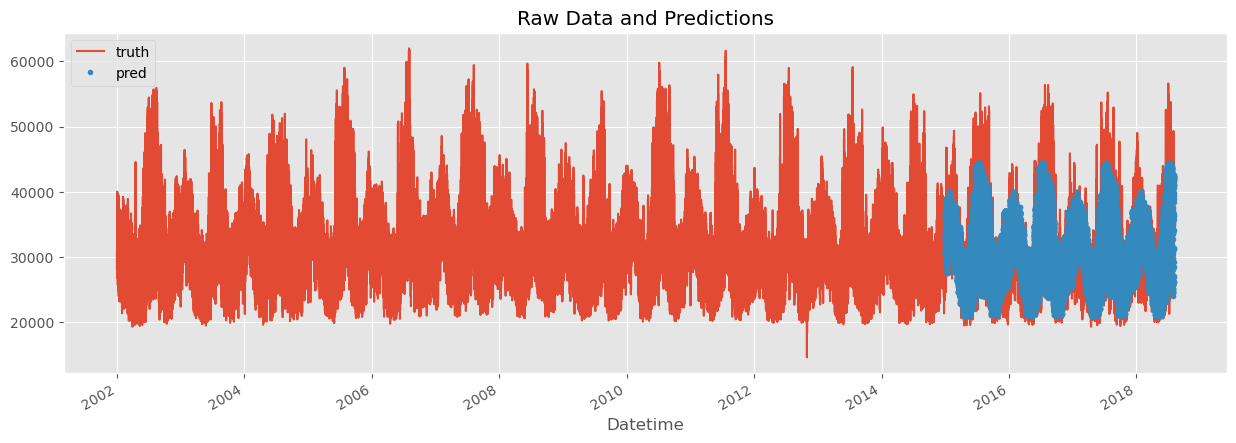

In [23]:
ax = df['PJME_MW'].plot(figsize = (15,5))
df.prediction.plot(ax = ax, style = '.')
plt.legend(['truth', 'pred'])
ax.set_title('Raw Data and Predictions')
plt.show()


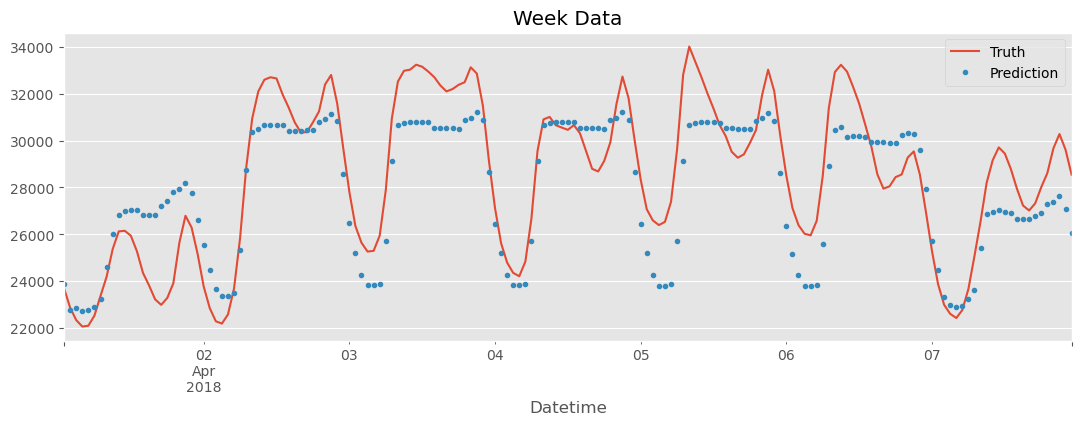

In [24]:
ax = df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['PJME_MW'].plot(figsize = (13, 4), title = 'Week Data')
df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['prediction'].plot(style = '.')
plt.legend(['Truth', 'Prediction'])
plt.show()

In [25]:
score = np.sqrt(mean_squared_error(test['PJME_MW'], test['prediction']))
print(f"RMSE of the model is {score:0.2f}")

RMSE of the model is 3714.53


In [26]:
test['error'] = np.abs(test[TARGET] - test['prediction'])

In [27]:
test['date'] = test.index.date

In [28]:
test.groupby('date')['error'].mean().sort_values(ascending = False).head()

date
2016-08-13    14559.813965
2016-08-14    14393.350911
2016-09-10    12564.790202
2016-08-12    11527.895264
2016-09-09    11432.962240
Name: error, dtype: float64

In [29]:
test.groupby('date')['error'].mean().sort_values(ascending = True).head()

date
2016-09-27    376.074544
2016-05-01    420.460286
2016-04-04    432.775065
2015-03-10    444.994792
2016-12-08    480.121663
Name: error, dtype: float64